# Setup

In [1]:
## Python Libraries Needed
#%pip install networkx
#%pip install scipy
#%pip install matplotlib
#%pip install tqdm
#%pip install pydot
#%pip install pygraphviz

## Other software : graphviz
#brew install graphviz (on mac)

In [2]:
import math
import time
import scipy
import random
import matplotlib.pyplot as plt
import networkx as nx
from IPython.utils import io
from IPython import display
import multiprocessing
import pydot
from networkx.drawing.nx_pydot import graphviz_layout #deprecated
from networkx.drawing.nx_agraph import graphviz_layout #new
from matplotlib import animation
#from tqdm.notebook import tqdm_notebook

# Drawing trees with graphviz

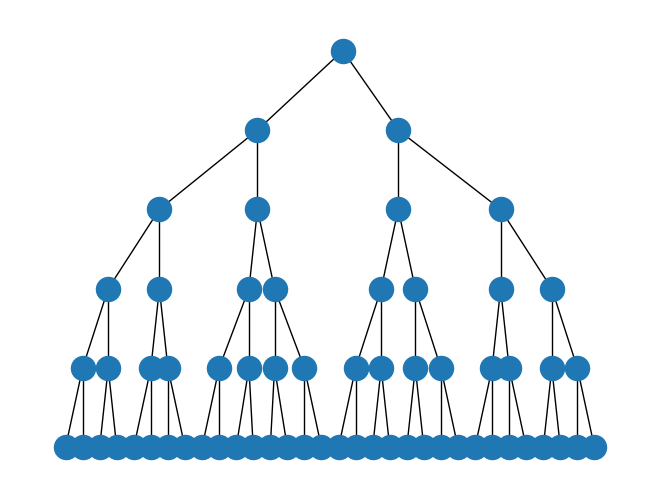

In [3]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

T = nx.balanced_tree(2, 5)

pos = graphviz_layout(T, prog="dot", args="-Grankdir=TB")
nx.draw(T, pos)
plt.show()

# Classes

In [4]:
class RandomTree:
    def __init__(self, nb_nodes, seed=None):
        self.tree = nx.random_tree(n=nb_nodes, create_using=nx.DiGraph, seed=seed)
        self.depth = max(nx.shortest_path_length(self.tree, 0).values())
        self.degree = max([len(self.tree[i]) for i in range(len(self.tree))])
    
    def draw(self):
        #nx.draw_networkx(self.tree)
        pos = graphviz_layout(self.tree, prog="dot")
        nx.draw(self.tree, pos)
        plt.show()

In [5]:
class Robot:
    def __init__(self, army, idx):
        self.army = army
        self.idx = idx
        self.position = 0
        self.anchor = 0
        self.stack = []
    
    def reanchor(self):
        closest_border_nodes = self.army.closest_border_nodes
        if len(closest_border_nodes) == 0:
            # The tree is explored, the robot stays at the root
            self.anchor = 0
        else:
            # Assigns to anchor with minimum number of robots
            min_selected_nodes = [
                node for node in closest_border_nodes if closest_border_nodes[node] == min(closest_border_nodes.values())
            ]
            self.anchor = min_selected_nodes[0]
            self.army.closest_border_nodes[self.anchor] += 1
    
    def depth_next(self):
        potential_edges = [
            edge for edge in self.army.dangling_edges if edge[0] == self.position and edge not in self.army.selected_edges
        ]
        
        if len(potential_edges) == 0:
            self.up()
        else:
            move = potential_edges[0]
            self.army.selected_edges.append(move)
            self.position = move[1]
            self.army.discovered_tree.add_edge(*move)
            print("Robot {} is moving DN from {} to {}".format(self.idx, move[0], move[1]))
    
    def up(self):
        if self.position > 0:
            parent = next(self.army.discovered_tree.predecessors(self.position))
            self.position = parent
            print("Robot {} is moving up to {}".format(self.idx, parent))
        else:
            print("Robot {} stays at root".format(self.idx))
        

In [12]:
class Army:
    def __init__(self, random_tree, nb_robots):
        self.random_tree = random_tree
        self.tree = random_tree.tree
        self.round = 0
        
        self.robots = []
        for i in range(nb_robots):
            self.robots.append(Robot(self, i))
        self.rounds = [[0] * nb_robots]
        
        self.discovered_nodes = {0} #NEW - this is a Python set element (removes duplicates)
        self.discovered_tree = nx.DiGraph()
        self.discovered_tree.add_node(0)
        
        self.selected_edges = []
        self.dangling_edges = []
        
        # Keys = closest discovered nodes adjacent to some unexplored edge
        # Values = number of robots having selected the node
        self.closest_border_nodes = {0: 0}
    
    def next_round(self, verbose=True):
        previous_pos = self.rounds[self.round].copy()
        self.rounds.append(previous_pos)
        self.round += 1
        self.update_border()
        if verbose: 
            print("**** ROUND {} ****".format(self.round))
        
        for (idx, robot) in enumerate(self.robots):
            if robot.position == 0:
                if verbose: 
                    print("Robot {} is at root".format(idx))
                robot.reanchor()
                if verbose : 
                    print("Robot {} has a new anchor: {}".format(idx, robot.anchor))
                visited_nodes = nx.shortest_path(self.discovered_tree, 0, robot.anchor)
                for i in range(len(visited_nodes) - 1):
                    robot.stack.append((visited_nodes[i], visited_nodes[i+1]))

            if len(robot.stack) > 0:
                move = robot.stack.pop(0)
                self.selected_edges.append(move)
                robot.position = move[1]
                if verbose :
                    print("Robot {} is moving BF from {} to {}".format(idx, move[0], move[1]))
            else:
                robot.depth_next()
                
            self.rounds[self.round][idx] = robot.position
        self.discovered_nodes = self.discovered_nodes.union(set([robot.position for robot in self.robots])) # NEW
        
    def update_border(self):
        # Find discovered nodes adjacent to some unexplored edge
        border_nodes = []
        self.dangling_edges = []
        for e in self.tree.edges:
            if e[0] in self.discovered_tree.nodes and e[1] not in self.discovered_tree.nodes: 
                if e[0] not in border_nodes:
                    border_nodes.append(e[0])
                self.dangling_edges.append(e)
        
        # Find the depths of border nodes
        border_depths = {
            node: nx.shortest_path_length(self.discovered_tree, 0, node) for node in border_nodes
        }
        
        # Return closest border nodes
        self.closest_border_nodes = {
            node: 0 for node in border_depths if border_depths[node] == min(border_depths.values())
        }
    
    def play(self):
        print("Tree size: {}".format(len(self.tree)))
        print("Number of robots: {}".format(len(self.robots)))
        print("Tree depth: {}".format(self.random_tree.depth))
        print("Tree degree: {}".format(self.random_tree.degree))
        print("Expected time: {:.0f}".format(
            2*len(self.tree)/len(self.robots) + math.pow(self.random_tree.depth, 2) * (
                min(math.log(len(self.robots)), math.log(self.random_tree.degree)) + 2
            )
        ))
        print()

        time_start = time.perf_counter()
        while self.round == 0 or self.rounds[-1] != [0] * len(self.robots) or len(self.closest_border_nodes) > 0:
            self.next_round()
            
            colors= []
            for n in list(self.tree.nodes):
                if n in set([robot.position for robot in self.robots]):
                    colors.append("green")
                elif n in self.discovered_nodes:
                    colors.append("blue")
                else:
                    colors.append("red")
            
            print("{:.0f}% of nodes have been discovered".format(len(self.discovered_tree) * 100 / len(self.tree)))
            pos = graphviz_layout(self.tree, prog="dot")
            nx.draw(self.tree, pos, with_labels=True, node_color = colors)
            plt.show()
        
        time_elapsed = time.perf_counter() - time_start
        print("Exploration ended in {} rounds and {:.1f} seconds".format(len(self.rounds), time_elapsed))
        
        return time_elapsed
    
    def play_animation(self,online=True,fps=1,savename="explo.gif"):
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        
        def gen():
            while self.round == 0 or self.rounds[-1] != [0] * len(self.robots) or len(self.closest_border_nodes) > 0:
                yield 1
        
        def init():
            pos = graphviz_layout(self.tree, prog="dot")
            ret = nx.draw(self.tree, pos, ax=ax)
            return ret

        def animate(i):
            #print(i, set([robot.position for robot in self.robots]))
            #print(i, self.discovered_nodes)
            colors = []
            color_edges = dict.fromkeys(self.tree.edges,"blue")
            for n in list(self.tree.nodes):
                if n in set([robot.position for robot in self.robots]):
                    colors.append("green")
                elif n in self.discovered_nodes:
                    colors.append("blue")
                else:
                    if online:
                        colors.append("white")
                        for e in self.tree.edges(n):
                            #print(n, " is adjacent to ",e)
                            color_edges[e]="white"
                    else:
                        colors.append("red")
                        for e in self.tree.edges(n):
                            #print(n, " is adjacent to ",e)
                            color_edges[e]="red"
            
            #print(color_edges)
            print("{:.0f}% of nodes have been discovered".format(len(self.discovered_tree) * 100 / len(self.tree)))
            pos = graphviz_layout(self.tree, prog="dot")
            nx.draw(self.tree, pos, with_labels=not(online), node_color = colors, edge_color=color_edges.values(),ax=ax)
            #print(color_edges.values())
            self.next_round(verbose=False)
        
        anim = animation.FuncAnimation(fig, animate, init_func=init,frames=gen,interval=1, repeat=True)
        writervideo = animation.PillowWriter(fps=fps)
        anim.save("out/"+savename, writer=writervideo, dpi=100) #default is 80 (slightly insufficient)
        #display.HTML('<img src="{}">'.format("exploration.gif"))

# Test

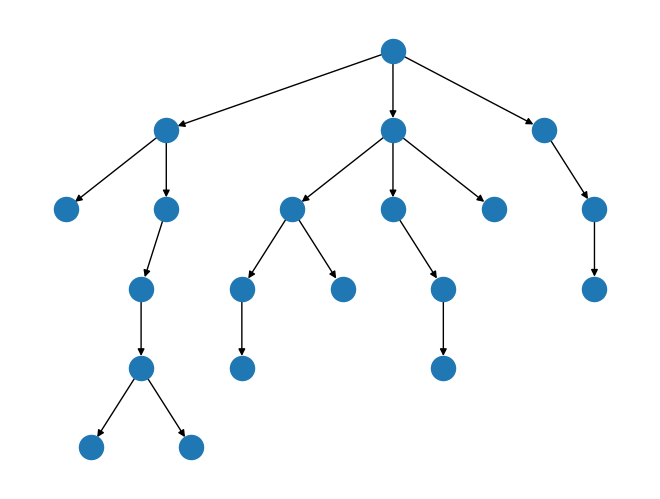

In [7]:
n = 20
k = 2

random_tree = RandomTree(n, seed=1) #seed 1 / 6 /12
random_tree.draw()

/var/folders/lt/12n5d39d2492fhn82s7drn6cg84_mn/T/ipykernel_3054/791865519.py:151: UserWarning: frames=<function Army.play_animation.<locals>.gen at 0x117eecf40> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = animation.FuncAnimation(fig, animate, init_func=init,frames=gen,interval=1, repeat=True)


5% of nodes have been discovered
Robot 0 is moving DN from 0 to 15
10% of nodes have been discovered
Robot 0 is moving DN from 15 to 8
15% of nodes have been discovered
Robot 0 is moving DN from 8 to 2
20% of nodes have been discovered
Robot 0 is moving DN from 2 to 5
25% of nodes have been discovered
Robot 0 is moving up to 2
25% of nodes have been discovered
Robot 0 is moving up to 8
25% of nodes have been discovered
Robot 0 is moving up to 15
25% of nodes have been discovered
Robot 0 is moving DN from 15 to 10
30% of nodes have been discovered
Robot 0 is moving up to 15
30% of nodes have been discovered
Robot 0 is moving DN from 15 to 3
35% of nodes have been discovered
Robot 0 is moving DN from 3 to 7
40% of nodes have been discovered
Robot 0 is moving up to 3
40% of nodes have been discovered
Robot 0 is moving DN from 3 to 6
45% of nodes have been discovered
Robot 0 is moving DN from 6 to 16
50% of nodes have been discovered
Robot 0 is moving up to 6
50% of nodes have been discove

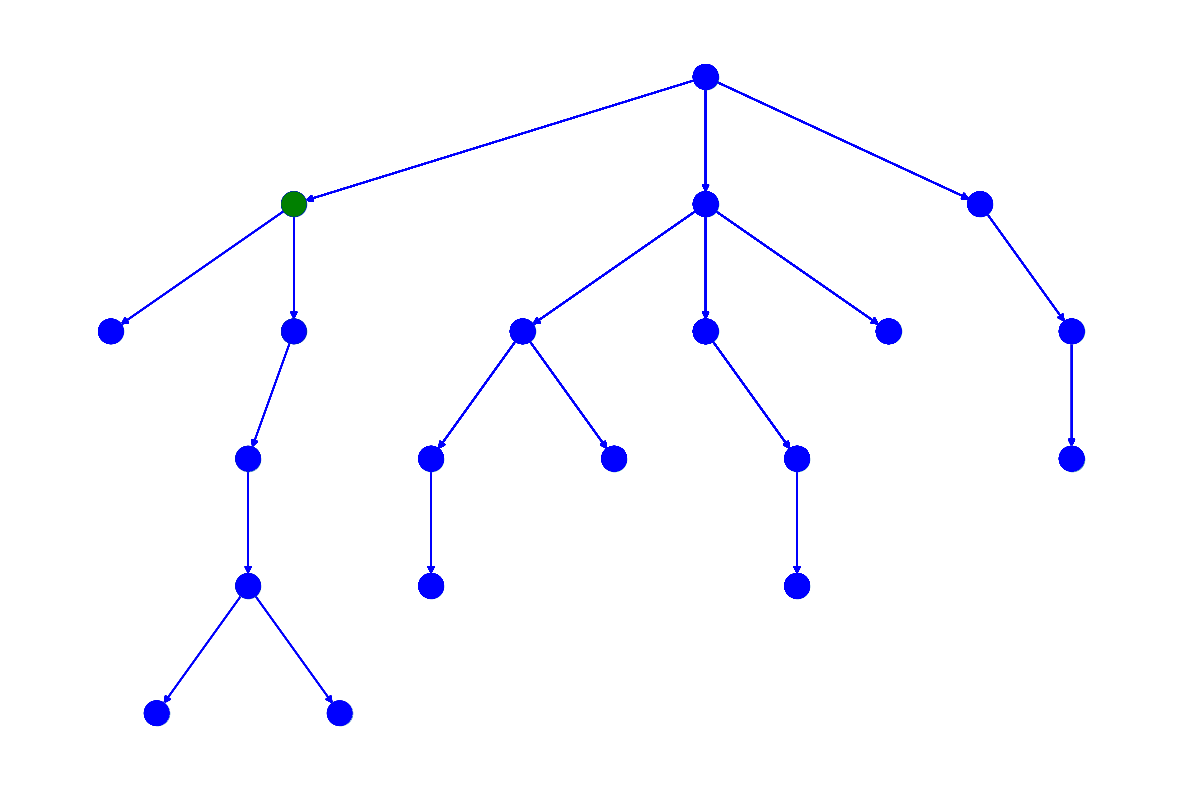

In [13]:
army = Army(random_tree, 1)
army.play_animation(online=True,fps=4,savename="very_slow.gif")

Tree size: 20
Number of robots: 2
Tree depth: 5
Tree degree: 3
Expected time: 87

**** ROUND 1 ****
Robot 0 is at root
Robot 0 has a new anchor: 0
Robot 0 is moving DN from 0 to 15
Robot 1 is at root
Robot 1 has a new anchor: 0
Robot 1 is moving DN from 0 to 18
15% of nodes have been discovered


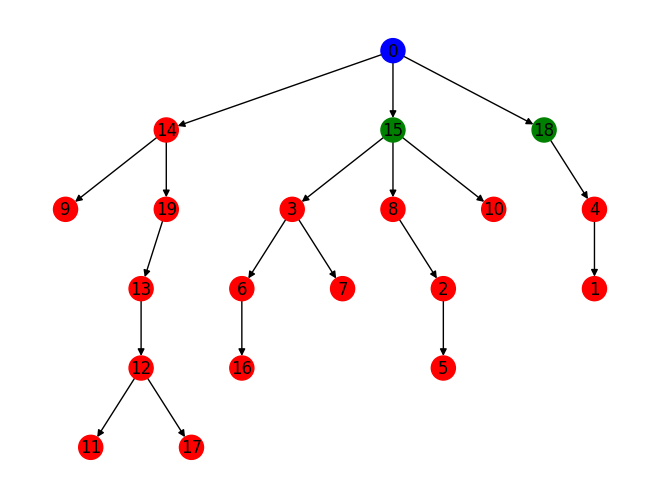

**** ROUND 2 ****
Robot 0 is moving DN from 15 to 8
Robot 1 is moving DN from 18 to 4
25% of nodes have been discovered


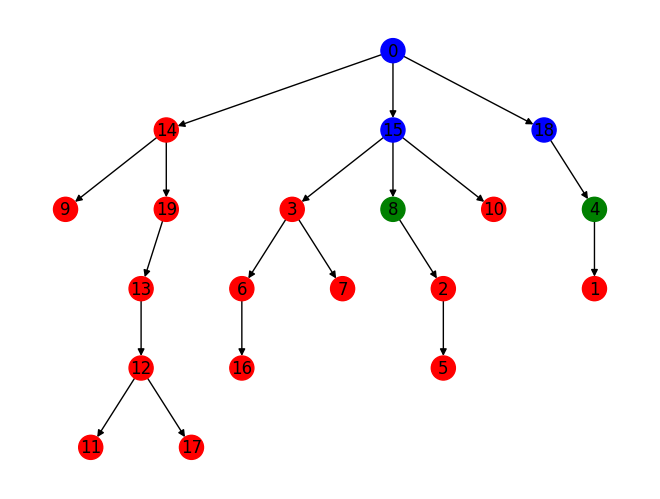

**** ROUND 3 ****
Robot 0 is moving DN from 8 to 2
Robot 1 is moving DN from 4 to 1
35% of nodes have been discovered


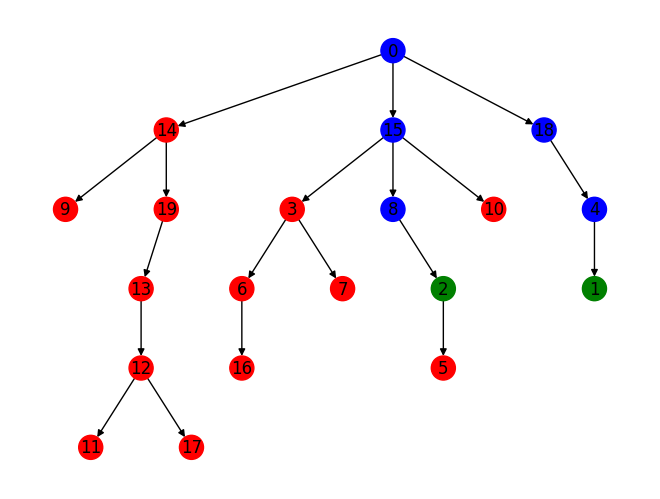

**** ROUND 4 ****
Robot 0 is moving DN from 2 to 5
Robot 1 is moving up to 4
40% of nodes have been discovered


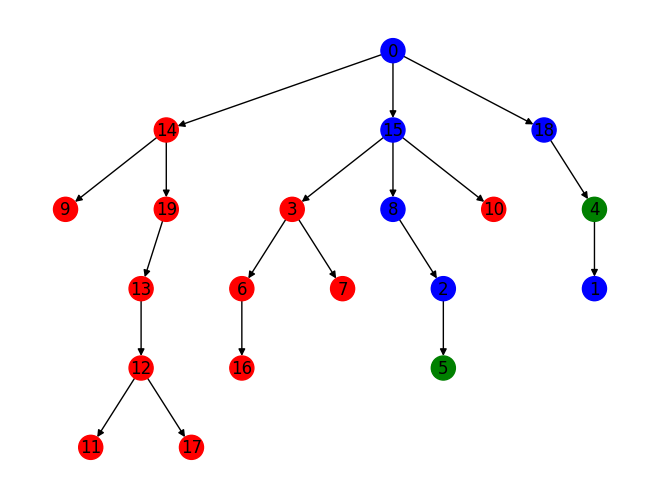

**** ROUND 5 ****
Robot 0 is moving up to 2
Robot 1 is moving up to 18
40% of nodes have been discovered


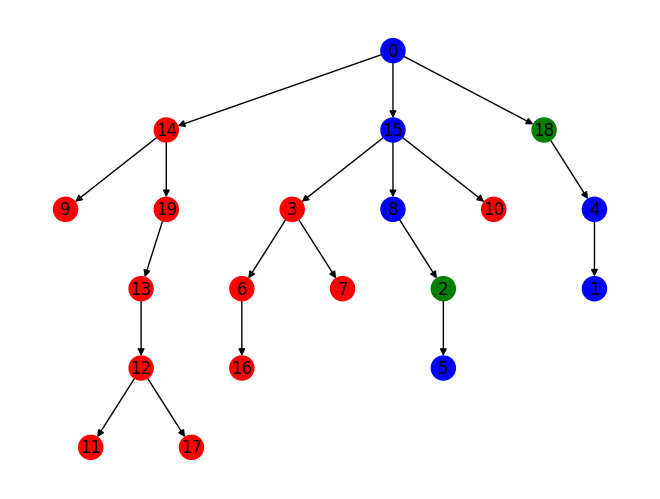

**** ROUND 6 ****
Robot 0 is moving up to 8
Robot 1 is moving up to 0
40% of nodes have been discovered


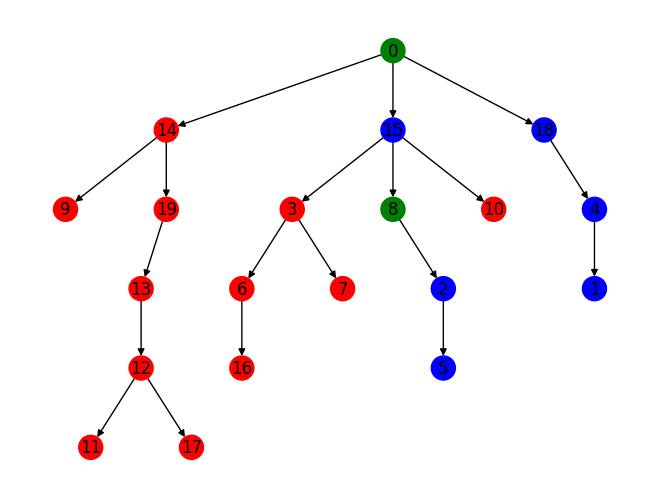

**** ROUND 7 ****
Robot 0 is moving up to 15
Robot 1 is at root
Robot 1 has a new anchor: 0
Robot 1 is moving DN from 0 to 14
45% of nodes have been discovered


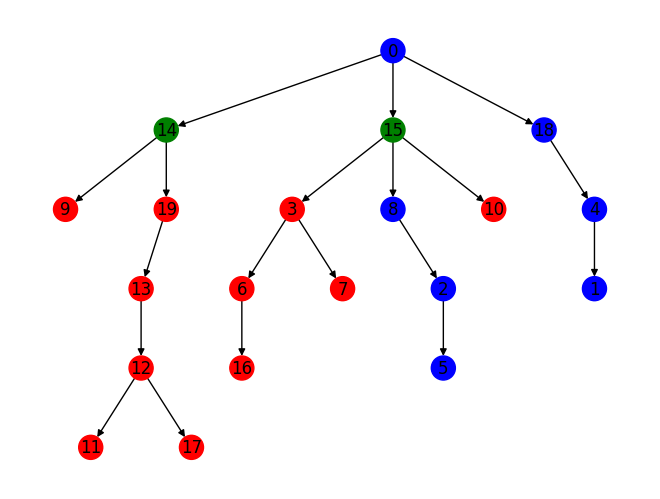

**** ROUND 8 ****
Robot 0 is moving DN from 15 to 10
Robot 1 is moving DN from 14 to 9
55% of nodes have been discovered


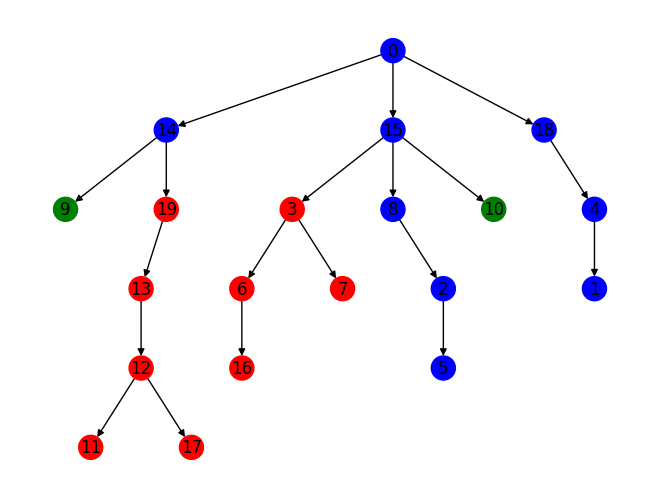

**** ROUND 9 ****
Robot 0 is moving up to 15
Robot 1 is moving up to 14
55% of nodes have been discovered


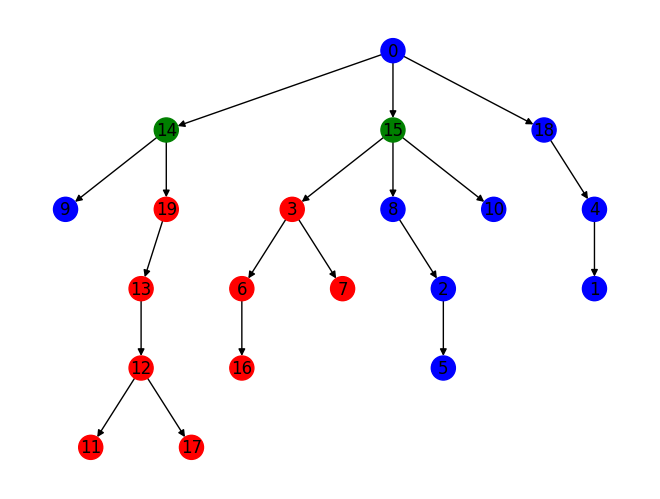

**** ROUND 10 ****
Robot 0 is moving DN from 15 to 3
Robot 1 is moving DN from 14 to 19
65% of nodes have been discovered


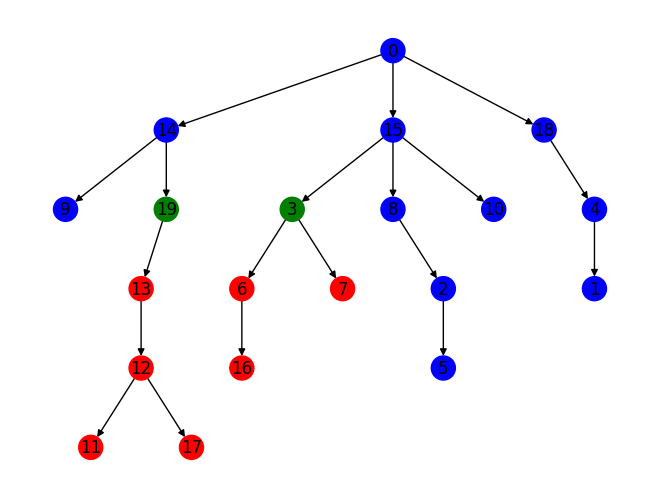

**** ROUND 11 ****
Robot 0 is moving DN from 3 to 7
Robot 1 is moving DN from 19 to 13
75% of nodes have been discovered


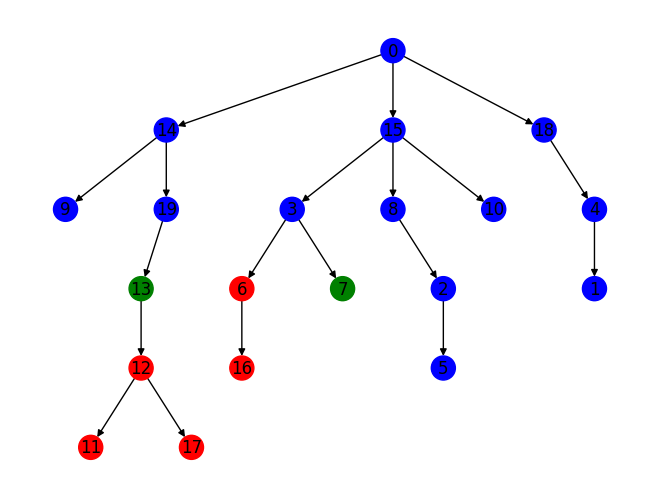

**** ROUND 12 ****
Robot 0 is moving up to 3
Robot 1 is moving DN from 13 to 12
80% of nodes have been discovered


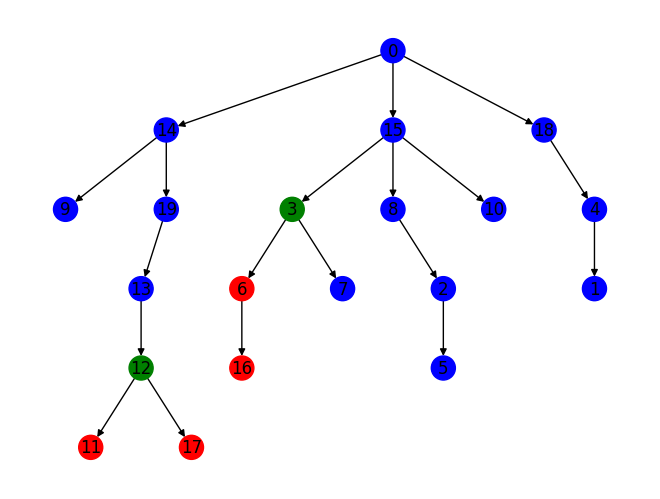

**** ROUND 13 ****
Robot 0 is moving DN from 3 to 6
Robot 1 is moving DN from 12 to 11
90% of nodes have been discovered


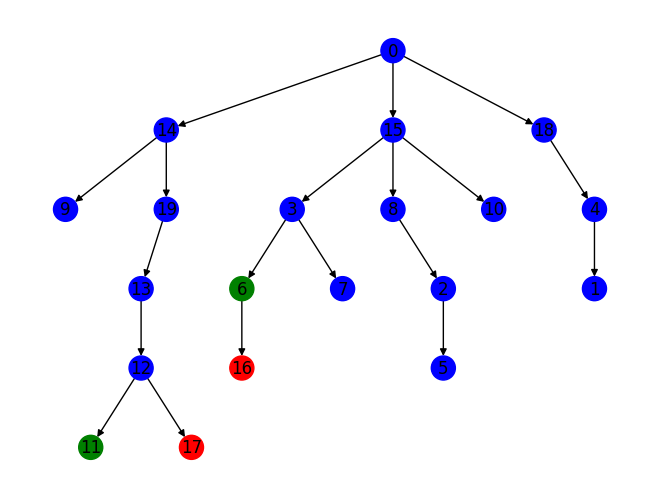

**** ROUND 14 ****
Robot 0 is moving DN from 6 to 16
Robot 1 is moving up to 12
95% of nodes have been discovered


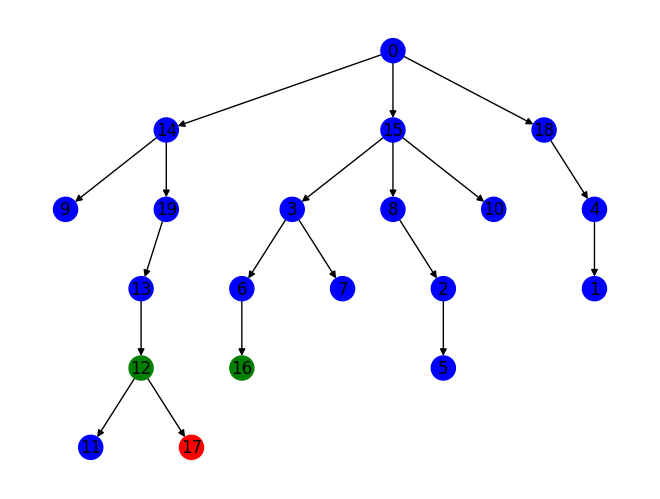

**** ROUND 15 ****
Robot 0 is moving up to 6
Robot 1 is moving DN from 12 to 17
100% of nodes have been discovered


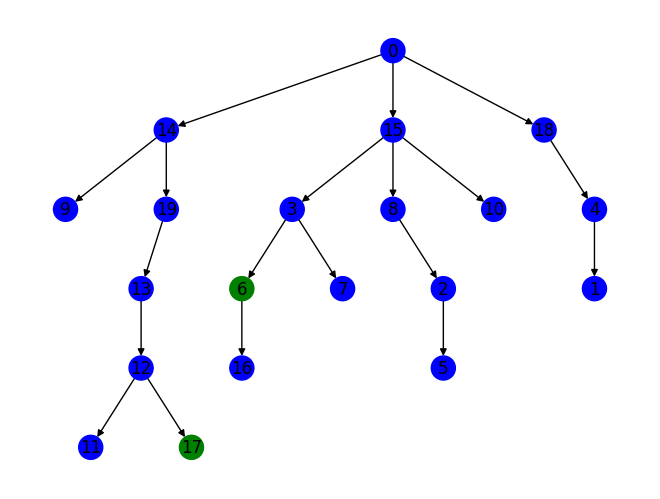

**** ROUND 16 ****
Robot 0 is moving up to 3
Robot 1 is moving up to 12
100% of nodes have been discovered


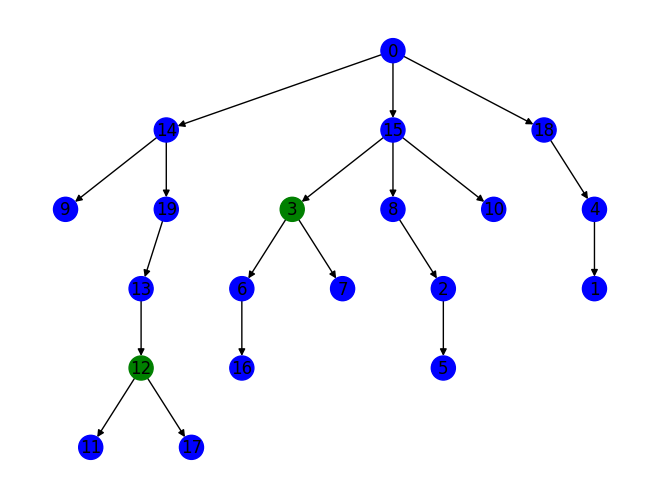

**** ROUND 17 ****
Robot 0 is moving up to 15
Robot 1 is moving up to 13
100% of nodes have been discovered


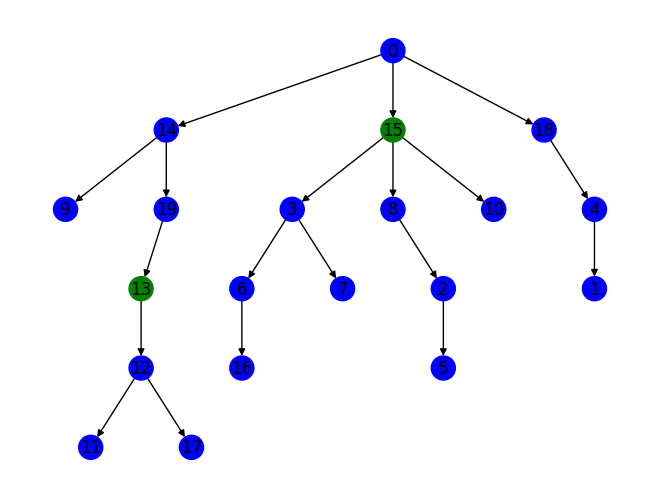

**** ROUND 18 ****
Robot 0 is moving up to 0
Robot 1 is moving up to 19
100% of nodes have been discovered


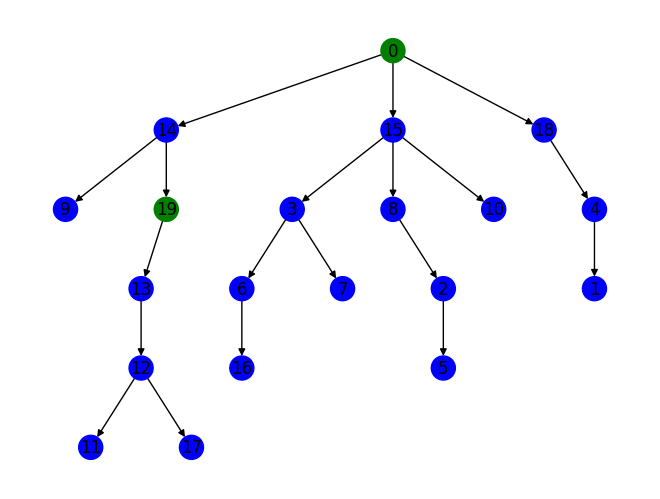

**** ROUND 19 ****
Robot 0 is at root
Robot 0 has a new anchor: 0
Robot 0 stays at root
Robot 1 is moving up to 14
100% of nodes have been discovered


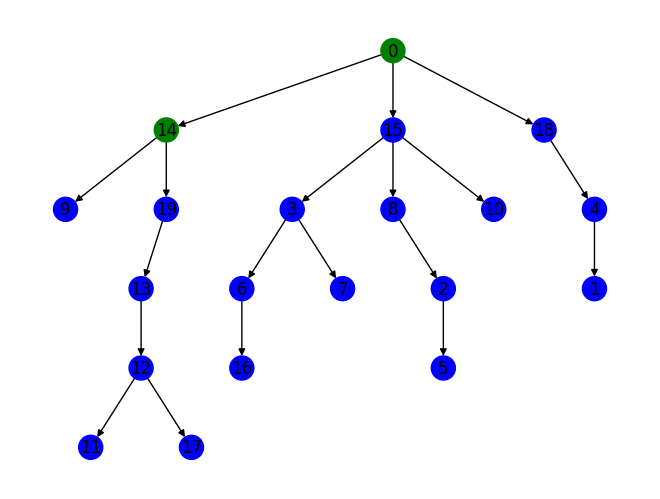

**** ROUND 20 ****
Robot 0 is at root
Robot 0 has a new anchor: 0
Robot 0 stays at root
Robot 1 is moving up to 0
100% of nodes have been discovered


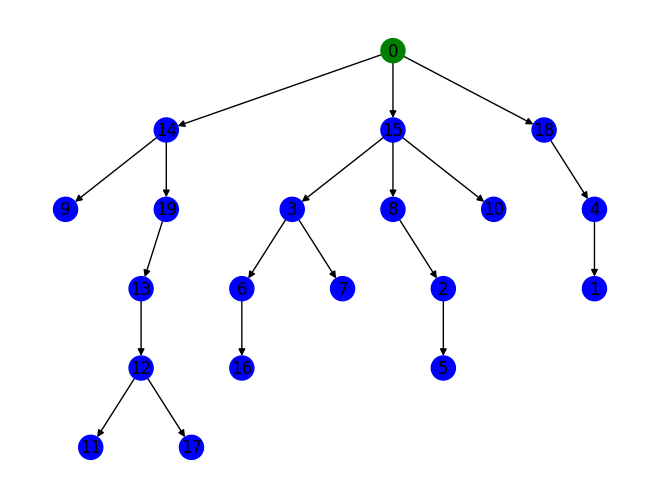

Exploration ended in 21 rounds and 6.6 seconds


6.5687478330219164

In [9]:
# Generate robots
army = Army(random_tree, k)
army.play()